In [ ]:
from pprint import pprint

import matplotlib.pyplot as plt
import torch
from torchmetrics.detection import MeanAveragePrecision

from data.build_dataset import build_dataset, collate_fn
from data.dataset_classes import VOC_DICT
from models.build_model import build_model
from utils.utils import visualize_image

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

configs = {
    "dataset": {"path": "/home/zhuangyifan/datasets/voc", "name": "voc"},
    "model": {"name": "faster_rcnn", "num_classes": 20, "freeze_backbone": True, "cosine_similarity": False},
    "train": {"crop_size": 256},
    "val": {"crop_size": -1},
}

In [3]:
# Initialize the dataloader.
dataset = build_dataset(configs, "train")
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn,
    drop_last=True,
)
dataloader_iter = iter(dataloader)

In [6]:
# Initialize the model.
model = build_model(configs).to(device)

for name, param in model.named_parameters():
    print("{}:".format(name), param.requires_grad)

model.backbone.body.conv1.weight: False
model.backbone.body.bn1.weight: False
model.backbone.body.bn1.bias: False
model.backbone.body.layer1.0.conv1.weight: False
model.backbone.body.layer1.0.bn1.weight: False
model.backbone.body.layer1.0.bn1.bias: False
model.backbone.body.layer1.0.conv2.weight: False
model.backbone.body.layer1.0.bn2.weight: False
model.backbone.body.layer1.0.bn2.bias: False
model.backbone.body.layer1.0.conv3.weight: False
model.backbone.body.layer1.0.bn3.weight: False
model.backbone.body.layer1.0.bn3.bias: False
model.backbone.body.layer1.0.downsample.0.weight: False
model.backbone.body.layer1.0.downsample.1.weight: False
model.backbone.body.layer1.0.downsample.1.bias: False
model.backbone.body.layer1.1.conv1.weight: False
model.backbone.body.layer1.1.bn1.weight: False
model.backbone.body.layer1.1.bn1.bias: False
model.backbone.body.layer1.1.conv2.weight: False
model.backbone.body.layer1.1.bn2.weight: False
model.backbone.body.layer1.1.bn2.bias: False
model.backbone.

In [8]:
# Run training and return loss.
images, targets = next(dataloader_iter)

images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

loss_dict = model(images, targets)
print(loss_dict.keys())

dict_keys(['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg'])


In [ ]:
# Run inference.
model.eval()
metric = MeanAveragePrecision(iou_type="bbox")

with torch.no_grad():
    predictions = model(images)
    metric.update(predictions, targets)

pprint(metric.compute())

metric.reset()

In [11]:
pprint(predictions[0])

{'boxes': tensor([[7.6572e+01, 2.8120e+01, 2.2032e+02, 2.5600e+02],
        [4.8392e+01, 6.4826e+01, 1.0795e+02, 2.4485e+02],
        [3.8528e+01, 7.0996e+01, 1.5118e+02, 2.5600e+02],
        [1.8495e+02, 7.1116e+01, 2.5600e+02, 2.5600e+02],
        [8.0533e+01, 1.4951e+02, 1.9831e+02, 2.5600e+02],
        [0.0000e+00, 1.4508e+01, 2.2891e+02, 1.3977e+02],
        [1.7766e+02, 1.7351e+02, 2.5595e+02, 2.5600e+02],
        [4.8464e+01, 1.1106e+02, 1.3762e+02, 2.0733e+02],
        [1.9861e+02, 2.0635e+02, 2.5466e+02, 2.5600e+02],
        [4.8261e+00, 5.9150e+01, 1.2776e+02, 1.7658e+02],
        [2.2502e+01, 5.0228e+01, 9.3857e+01, 2.0438e+02],
        [7.4772e+01, 9.8073e+01, 1.7825e+02, 2.0879e+02],
        [1.2413e+00, 1.5295e+02, 6.9105e+01, 1.8383e+02],
        [9.2122e+01, 7.7417e+01, 2.1043e+02, 1.9279e+02],
        [7.4044e+01, 2.0393e+02, 1.3492e+02, 2.5600e+02],
        [2.1281e+02, 1.5745e+02, 2.5551e+02, 2.5600e+02],
        [1.0288e+01, 1.2942e+02, 4.7046e+01, 1.7586e+02],
    

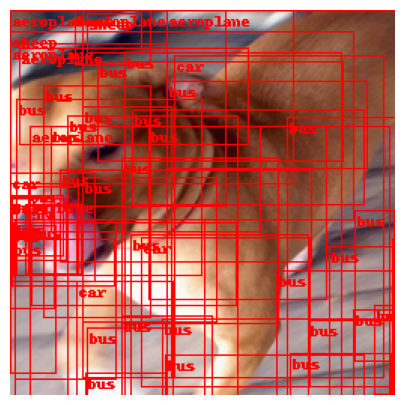

In [20]:
# Visualize predictions.
pred_boxes = predictions[0]["boxes"].cpu()
pred_labels = predictions[0]["labels"].cpu()
pred_scores = predictions[0]["scores"].cpu()

filtered_boxes = pred_boxes[pred_scores > 0.1]
filtered_labels = pred_labels[pred_scores > 0.1]

labels = [list(VOC_DICT.keys())[int(idx)] for idx in filtered_labels]
image_vis = visualize_image(images[0].cpu(), filtered_boxes, labels).numpy()

plt.figure(figsize=(5, 5))
plt.imshow(image_vis)
plt.axis("off")
plt.show()